/work/jleugeri/decoding/local/lib/python2.7/site-packages/matplotlib/__init__.py:1039: UserWarning: Bad val "pyside" on line #38
	"backend      : pyside
"
	in file "/work/jleugeri/decoding/local/lib/python2.7/site-packages/matplotlib/mpl-data/matplotlibrc"
	Key backend: Unrecognized backend string "pyside": valid strings are [u'pgf', u'cairo', u'MacOSX', u'CocoaAgg', u'gdk', u'ps', u'GTKAgg', u'nbAgg', u'GTK', u'Qt5Agg', u'template', u'emf', u'GTK3Cairo', u'GTK3Agg', u'WX', u'Qt4Agg', u'TkAgg', u'agg', u'svg', u'GTKCairo', u'WXAgg', u'WebAgg', u'pdf']
  (val, error_details, msg))


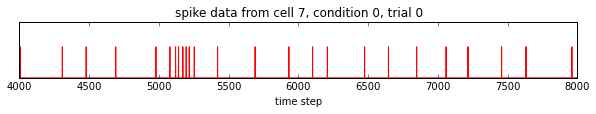

In [1]:
from matplotlib.pyplot import *
%matplotlib inline
import numpy as np
import pandas

cell = 7
condition = 0
dataframe = pandas.read_pickle('../data/Moving_bars_ouput_cell_'+str(cell)+'.pkl')
# TODO RELATIVE PATH


figure(figsize=(10,1))
trial = 0
single_spiketrain = dataframe.ix[(condition,trial,0),4000:8000]
plot(np.arange(4000,8001),single_spiketrain,'r')
title('spike data from cell '+str(cell)+', condition '+str(condition)+', trial '+str(trial))
ylim([0,1.8])
yticks([])
xlabel('time step')

In [2]:
# collect spiketrains from all trials of that cell & condition, within some time limits
trials = []
trial = 0
while True:
    try:
        trials.append(dataframe.ix[(condition,trial,0),4000:8000])
        trial += 1
    except:
        break
        
T = len(trials[0])
N = len(trials)
all_spiketrains = np.hstack(trials)

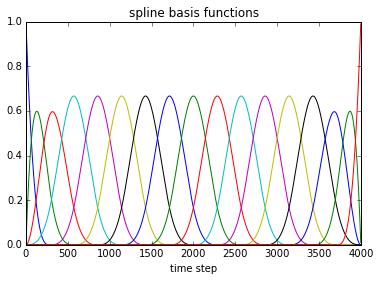

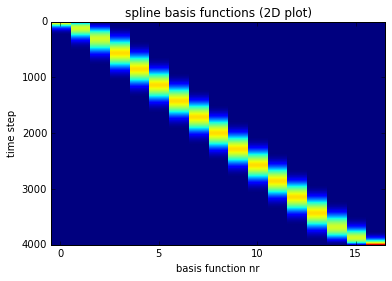

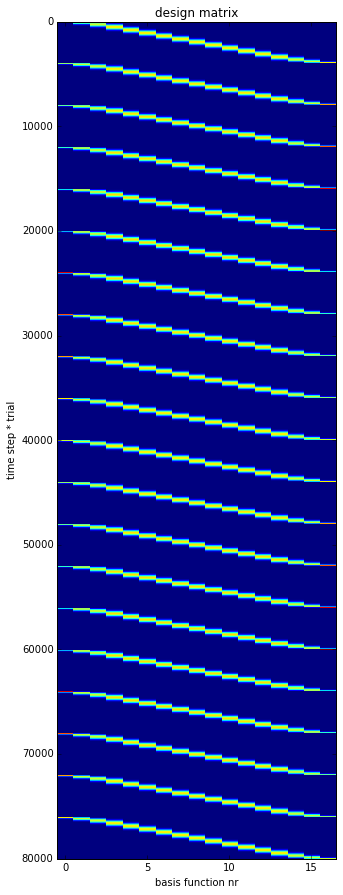

In [3]:
import splines
import statsmodels.api as sm


# spline_order = ...
# knots = ...
# spline_bases = ...
# dm = ...

# model = sm.GLM(...)
# fitted_model = model.fit()
# prediction = fitted_model.predict(...)



spline_order = 3                                                      # solution
knots = splines.augknt(np.linspace(0,T,15),spline_order)              # solution
spline_bases = np.array(splines.spcol(range(T),knots,spline_order))   # solution
dm = np.tile(spline_bases,(N,1))                                      # solution

model = sm.GLM(all_spiketrains,dm,family=sm.families.Binomial())      # solution
fitted_model = model.fit()                                            # solution
prediction = fitted_model.predict(spline_bases)                       # solution



figure()
plot(spline_bases)
title('spline basis functions')
xlabel('time step')

figure()
imshow(spline_bases,aspect='auto',interpolation='nearest')
title('spline basis functions (2D plot)')
ylabel('time step')
xlabel('basis function nr')

figure(figsize=(5,15))
imshow(dm,aspect='auto',interpolation='nearest')
title('design matrix')
ylabel('time step * trial')
xlabel('basis function nr')

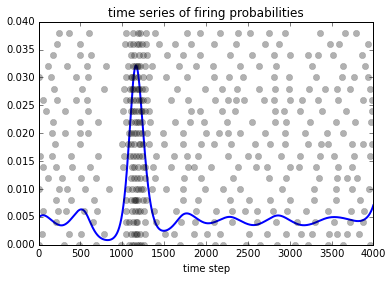

In [4]:
spike_t = np.where(all_spiketrains)[0]
spike_y = (spike_t/T)*0.04/N
spike_t%= T

figure()
plot(prediction,linewidth=2)
plot(spike_t,spike_y,"ko", alpha=0.3)
ylim([0,0.04])
title('time series of firing probabilities')
xlabel('time step')

Number of knots: 5.  Log-Likelihood: -2701.66
Number of knots: 10.  Log-Likelihood: -2688.19
Number of knots: 20.  Log-Likelihood: -2630.78
Number of knots: 30.  Log-Likelihood: -2633.93
Number of knots: 50.  Log-Likelihood: -2648.37
The highest likelihood of -2630.78 was found for 20 knots.


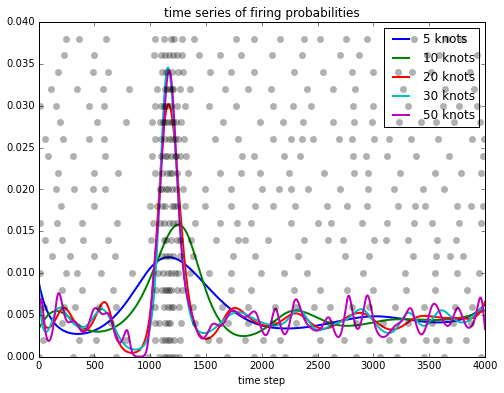

In [10]:
#def ll(ps,xs):
#    ...

def ll(ps,xs):                                                                 # solution
    return sum(xs*np.log(ps) +(1 - xs) * np.log(1-ps))                         # solution

num_knots_candidates = [5, 10, 20, 30 ,50]

best_loglikelihood = -np.inf
best_num_knots     = None

figure(figsize=(8,6))
for num_knots in num_knots_candidates:
#    ...
    knots = splines.augknt(np.linspace(0,T,num_knots),spline_order)              # solution
    spline_bases = np.array(splines.spcol(range(T),knots,spline_order))          # solution
    dm = np.tile(spline_bases,(N-1,1))                                           # solution
    # Calculate the joint log-likelihood of all test-sets                        # solution
    loglikelihood = 0                                                            # solution
    for i,test in enumerate(trials):                                             # solution
        train = trials[:i] + trials[i+1:]                                        # solution
        model = sm.GLM(np.hstack(train),dm,family=sm.families.Binomial())        # solution
        fitted_model = model.fit()                                               # solution
        prediction = fitted_model.predict(spline_bases)                          # solution
        loglikelihood += ll(prediction,test)                                     # solution
        # Plot the resulting prediction for the first trial                      # solution
        if i==0:                                                                 # solution
            plot(prediction,linewidth=2)                                         # solution
    # Update the current best number of knots                                    # solution
    if loglikelihood > best_loglikelihood:                                       # solution
        best_loglikelihood = loglikelihood                                       # solution
        best_num_knots = num_knots                                               # solution
    print "Number of knots: %d.  Log-Likelihood: %g" % (num_knots, loglikelihood)# solution


print "The highest log-likelihood of %g was found for %d knots." % (best_loglikelihood, best_num_knots)
plot(spike_t, spike_y, "ko", alpha=0.3)
legend(map(lambda n: "%d knots" % n, num_knots_candidates))
ylim([0,0.04])
title('time series of firing probabilities')
xlabel('time step');